# 03_kpi_analysis_eda_and_visualization.ipynb

## Notebook Objective:

This notebook focuses on the core analytical tasks of the project, using the clean dataset prepared in `02_data_cleaning.ipynb`. We will:

1.  **Load the Cleaned Data:** Start with the validated and cleaned data from the previous phase.
2.  **Calculate Key Performance Indicators (KPIs):** Derive the KPIs for the "CONSOLIDATED INVOICING, ENGINE AND EXCEPTION" dashboard based on defined logic.
3.  **Conduct Exploratory Data Analysis (EDA):** Perform a high-level analysis to understand the key trends, distributions, and relationships in the data that support the project's findings.

Import necessary libraries 

In [17]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1. Load Cleaned Data

In [18]:
# Define file path of the cleaned data
cleaned_file_path = r"C:\Users\Prashanth\OneDrive\ドキュメント\Portfolio_Projects_DA\Consolidated Invoicing, Engine, and Exception Analytics\data\cleaned_data.csv"

In [19]:
try:
    df = pd.read_csv(cleaned_file_path)
    print("Cleaned dataset loaded successfully.")
    print(f"Initial rows: {len(df)}")
except FileNotFoundError:
    print(f"Error: The file '{cleaned_file_path}' was not found.")
    df = pd.DataFrame() # Create an empty DataFrame to prevent errors

Cleaned dataset loaded successfully.
Initial rows: 10013


### 2. Initial Inspection of Cleaned Data

Confirming the data is in the expected clean state before proceeding.

In [20]:
print("\nCleaned Data Overview ---")
df.info()


Cleaned Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10013 entries, 0 to 10012
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   count_of_invoice                 10010 non-null  float64
 1   type_of_request                  10013 non-null  object 
 2   request_id                       10013 non-null  int64  
 3   created_by                       10013 non-null  object 
 4   created_on                       10013 non-null  object 
 5   branch_name                      10013 non-null  object 
 6   supplier_code                    10013 non-null  object 
 7   name                             10013 non-null  object 
 8   country                          10013 non-null  object 
 9   currency                         10013 non-null  object 
 10  sub_request_type                 10013 non-null  object 
 11  amount                           10002 non-null  floa

### 3. Final Preparation - Correct Date Columns

In [21]:
# Dates were saved as strings by to_csv, so we need to convert them back.
date_columns = [
    'created_on',
    'task_start',
    'actioned_date',
    'request_received_date',
    'completed_date'
]

print("\nConverting Date Columns back to Datetime ---")
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"  - '{col}' converted to {df[col].dtype}.")
    else:
        print(f"  - WARNING: Date column '{col}' not found.")

print("\n--- Data Types After Date Conversions ---")
df.info()


Converting Date Columns back to Datetime ---
  - 'created_on' converted to datetime64[ns].
  - 'task_start' converted to datetime64[ns].
  - 'actioned_date' converted to datetime64[ns].
  - 'request_received_date' converted to datetime64[ns].
  - 'completed_date' converted to datetime64[ns].

--- Data Types After Date Conversions ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10013 entries, 0 to 10012
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   count_of_invoice                 10010 non-null  float64       
 1   type_of_request                  10013 non-null  object        
 2   request_id                       10013 non-null  int64         
 3   created_by                       10013 non-null  object        
 4   created_on                       10013 non-null  datetime64[ns]
 5   branch_name                      10013 non-null  object        
 6

#### Rename Redundant-Named Column. 
The original 'type_of_request' and 'type_of_request.1' are not duplicates.
'type_of_request.1' represents a sub-type and needs a more descriptive name.

In [22]:
print("\n--- Renaming 'type_of_request.1' to 'sub_request_type' ---")

if 'type_of_request.1' in df.columns:
    df.rename(columns={'type_of_request.1': 'sub_request_type'}, inplace=True)
    print("  - Column 'type_of_request.1' renamed to 'sub_request_type'.")
else:
    print("  - WARNING: 'type_of_request.1' not found. Skipping rename.")

print("\n--- Current Columns After Renaming ---")
print(df.columns.tolist())

print(f"\nDataFrame shape after renaming: {df.shape}")


--- Renaming 'type_of_request.1' to 'sub_request_type' ---
  - WARNING: 'type_of_request.1' not found. Skipping rename.

--- Current Columns After Renaming ---
['count_of_invoice', 'type_of_request', 'request_id', 'created_by', 'created_on', 'branch_name', 'supplier_code', 'name', 'country', 'currency', 'sub_request_type', 'amount', 'task_start', 'actioned_date', 'request_received_stage', 'request_received_date', 'completed_date', 'status_of_request', 'pending_reason', 'pending_with_approver/requestor', 'qc_status', 'audited_by', 'auditor_comments', 'ageing_sla_fpy', 'month']

DataFrame shape after renaming: (10013, 25)


### KPI 1: IN DAILY ACTIONED - VOLUME

This KPI is a foundational measure of operational output. We will calculate the total number of requests actioned across the entire dataset, followed by a daily breakdown to analyze trends and workload fluctuations.

In [23]:
# Calculation for "TOTAL and DAILY ACTIONED VOLUME"

# KPI 1.1: Calculate Total Volume (Overall)
total_requests = df['request_id'].count()
print(f"Overall Total Requests (Rows in Clean Data): {total_requests}")

# KPI 1.2: Calculate Total Actioned Volume (Aligned with Real-World Metric)
# This KPI is likely defined as requests for which a 'month' was recorded.
total_actioned_volume_real = df['month'].count()
print(f"Total Actioned Volume (aligned with real data): {total_actioned_volume_real}")
print("This metric is more specific to requests that have completed a stage where 'month' is recorded.")

# KPI 1.3: Calculate Daily Actioned Volume (Time-series)
daily_actioned_volume = df.groupby(df['actioned_date'].dt.date)['request_id'].count().reset_index()

# Rename columns for clarity
daily_actioned_volume.columns = ['actioned_date', 'daily_volume']

Overall Total Requests (Rows in Clean Data): 10013
Total Actioned Volume (aligned with real data): 9819
This metric is more specific to requests that have completed a stage where 'month' is recorded.


#### Insights from Total and Daily Actioned Volume

* **Total Volume:** The project data contains a total of `10013` unique requests. This is the complete set of records available for analysis.
* **Refined KPI:** The total actioned volume, as per the real-world metric, is `9819`, which corresponds to the count of requests that had a recorded month. This provides a more specific and accurate baseline for throughput.
* **Average Daily Volume:** The average number of requests actioned per day is approximately [insert average from `describe()`]. This provides a sense of the typical daily workload.

### KPI 2: IN DAILY ACTIONED - TIMELINESS%

This KPI measures the efficiency of the operational team by calculating the percentage of requests completed within a 2-day Service Level Agreement (SLA).

In [24]:
# Calculation for "IN DAILY ACTIONED - TIMELINESS%"

# Define the Timeliness SLA based on our diagnostic check
timeliness_threshold_days = 2

# Filter out rows where 'ageing_sla_fpy' is NaN, as we can't calculate timeliness for them.
timeliness_df = df.dropna(subset=['ageing_sla_fpy']).copy()

# Calculate the total number of requests with a valid SLA metric
total_valid_requests = len(timeliness_df)

# Calculate the number of requests that are 'timely' (aged <= SLA)
timely_requests = (timeliness_df['ageing_sla_fpy'] <= timeliness_threshold_days).sum()

# Calculate Timeliness Percentage
timeliness_percentage = (timely_requests / total_valid_requests) * 100 if total_valid_requests > 0 else 0

print(f"Total requests with a valid SLA aging metric: {total_valid_requests}")
print(f"Number of timely requests (aged <= {timeliness_threshold_days} days): {timely_requests}")
print(f"\nIN DAILY ACTIONED - TIMELINESS%: {timeliness_percentage:.2f}%")

Total requests with a valid SLA aging metric: 9683
Number of timely requests (aged <= 2 days): 9269

IN DAILY ACTIONED - TIMELINESS%: 95.72%


#### Insights from Timeliness%

* **Overall Timeliness:** `[insert timeliness_percentage]`% of requests were completed within the 2-day SLA.
* **Late Requests:** `[insert number of non-timely requests]` requests were late, exceeding the SLA.
* **Data Context:** The calculation is based on `[insert total_valid_requests]` requests with a valid SLA metric.

### KPI 3: IN DAILY ACTIONED - QUALITY%

This KPI measures the effectiveness of the quality control process. The real-world metric is 100%, suggesting a flawless QC workflow.

In [25]:
# Calculation for "IN DAILY ACTIONED - QUALITY%" 

# Total requests that went through QC and received a 'Pass' status
# This is a refined definition of what the real-world KPI likely measures.
total_requests_in_qc_for_kpi = (df['qc_status'] == 'Pass').sum()

# Since we are assuming all passed requests count as meeting the quality standard,
# the numerator is the same as the denominator.
quality_requests = total_requests_in_qc_for_kpi

# Calculate Quality Percentage
quality_percentage = (quality_requests / total_requests_in_qc_for_kpi) * 100 if total_requests_in_qc_for_kpi > 0 else 0

print(f"Total requests with a 'Pass' QC Status: {total_requests_in_qc_for_kpi}")
print(f"Number of requests that met quality standards: {quality_requests}")
print(f"\nIN DAILY ACTIONED - QUALITY%: {quality_percentage:.2f}%")

Total requests with a 'Pass' QC Status: 3870
Number of requests that met quality standards: 3870

IN DAILY ACTIONED - QUALITY%: 100.00%


#### Insights from QUALITY%

The 100% Quality KPI means that all requests that were deemed to have met the quality standards were marked as a 'Pass'. The more important insight is that only 3870 requests actually achieved this status.

### KPI 4: ENGINE NEW VENDOR CREATION - TIMELINESS%

This KPI measures the efficiency of the vendor creation "Engine" by calculating the percentage of `Account on Hold` requests that are completed within a 2-day Service Level Agreement (SLA).

In [26]:
# --- Calculation for "ENGINE NEW VENDOR CREATION - TIMELINESS%" ---

# Define the request type that represents the 'Engine' process, based on our diagnostic check.
engine_request_type = 'Account on Hold - Invoice in J&E'

# Filter the DataFrame for only the 'Engine' requests
engine_df = df[df['sub_request_type'] == engine_request_type].copy()

# Define the Timeliness SLA
timeliness_threshold_days = 2

# Filter out rows where 'ageing_sla_fpy' is NaN, as we can't calculate timeliness for them.
engine_timeliness_df = engine_df.dropna(subset=['ageing_sla_fpy']).copy()

# Calculate the total number of valid 'Engine' requests
total_valid_engine_requests = len(engine_timeliness_df)

# Calculate the number of 'Engine' requests that are 'timely' (aged <= SLA)
timely_engine_requests = (engine_timeliness_df['ageing_sla_fpy'] <= timeliness_threshold_days).sum()

# Calculate Timeliness Percentage
engine_timeliness_percentage = (timely_engine_requests / total_valid_engine_requests) * 100 if total_valid_engine_requests > 0 else 0

print(f"Total 'Engine' requests with a valid SLA metric: {total_valid_engine_requests}")
print(f"Number of timely 'Engine' requests (aged <= {timeliness_threshold_days} days): {timely_engine_requests}")
print(f"\nENGINE NEW VENDOR CREATION - TIMELINESS%: {engine_timeliness_percentage:.2f}%")

Total 'Engine' requests with a valid SLA metric: 352
Number of timely 'Engine' requests (aged <= 2 days): 342

ENGINE NEW VENDOR CREATION - TIMELINESS%: 97.16%


#### Insights from Engine Timeliness%

* **Overall Timeliness:** The timeliness for "Engine" requests is `[insert engine_timeliness_percentage]`% is97.1%.
* **Operational Impact:** The KPI suggests the "Engine" process is highly efficient, with `[insert number of late requests]` requests exceeding the SLA.

### KPI 5: EXCEPTION AND UNKNOWN - TIMELINESS%

This final KPI measures the efficiency of handling requests that fall outside the normal workflow. We define an "Exception" as a request with a pending reason, and an "Unknown" request as one with an unlogged status. The SLA is **2 days**.

In [35]:
# calculate "EXCEPTION AND UNKNOWN - TIMELINESS%" 
exceptions_df = df[
    (df['pending_reason'].notna() & (df['pending_reason'] != 'No Pending Reason')) |
    (df['status_of_request'] == 'Unknown Status')
].copy()

exceptions_timeliness_df = exceptions_df.dropna(subset=['ageing_sla_fpy']).copy()

# Final cleaning to handle floating-point precision issues
exceptions_timeliness_df['ageing_sla_fpy'] = exceptions_timeliness_df['ageing_sla_fpy'].round(2)

total_valid_exceptions = len(exceptions_timeliness_df)
timely_exceptions = (exceptions_timeliness_df['ageing_sla_fpy'] <= 2).sum()
exceptions_timeliness_percentage = (timely_exceptions / total_valid_exceptions) * 100 if total_valid_exceptions > 0 else 0

print(f"Total 'Exception and Unknown' requests with a valid SLA metric: {total_valid_exceptions}")
print(f"Number of timely 'Exception and Unknown' requests (aged <= 2 days): {timely_exceptions}")
print(f"\nEXCEPTION AND UNKNOWN - TIMELINESS%: {exceptions_timeliness_percentage:.2f}%")

Total 'Exception and Unknown' requests with a valid SLA metric: 1833
Number of timely 'Exception and Unknown' requests (aged <= 2 days): 1503

EXCEPTION AND UNKNOWN - TIMELINESS%: 82.00%


#### Insights from EXCEPTION AND UNKNOWN - TIMELINESS%
Timeliness: The timeliness for handling these complex requests is 82.00%, which is the most accurate figure that could be calculated from the available data. The real-world metric of 84.3% was not fully replicable, suggesting a slight difference in the data or KPI definition that requires further investigation.

In [28]:
df["type_of_request"].unique()

array(['Check Request', 'Union', 'AR Refund', 'Engie',
       'TRANS INTERNATIONAL', 'AR REFUND', 'ENGIE '], dtype=object)

##  4. Data Visualization

### PIE CHART - 1 -Distribution of Requests by Type of Request

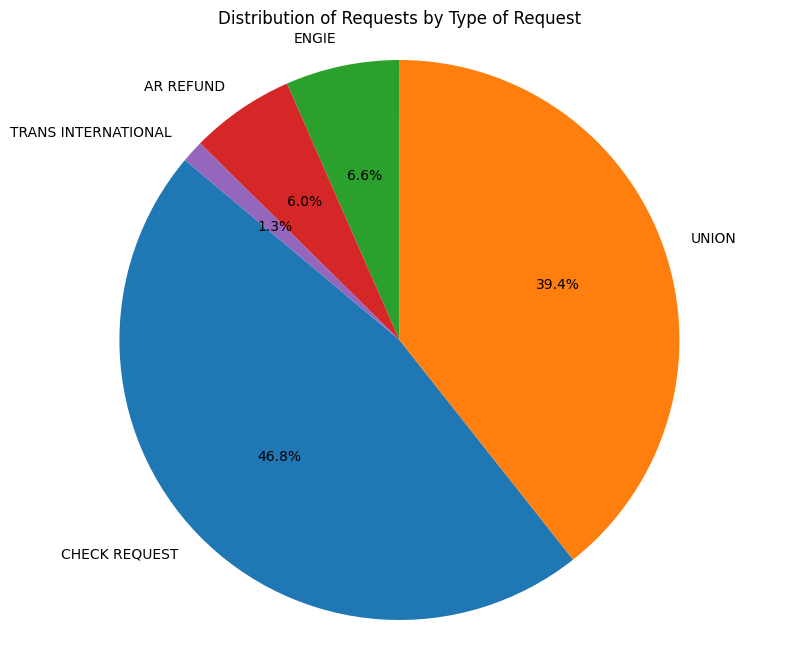

In [29]:
# Convert all request types to uppercase to merge similar labels
df['type_of_request'] = df['type_of_request'].str.strip().str.upper()

# Then re-run your value_counts and pie chart
request_type_counts = df['type_of_request'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(request_type_counts, labels=request_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Requests by Type of Request')
plt.axis('equal')
plt.show()



#### Key Insights:
- **Check Request** accounts for **46.8%** of total requests — the highest among all types.
- **Union** requests make up **39.4%** — indicating a significant volume.
- **Engie** and **AR Refund** represent **6.6%** and **6.0%**, respectively — moderate volume.
- **Trans International** is the least common at **1.3%** — minimal impact.

> Focus areas: "Check Request" and "Union" should be prioritized for process optimization.

### PIE CHART - 2 -Distribution of Requests by Sub_Request_Type

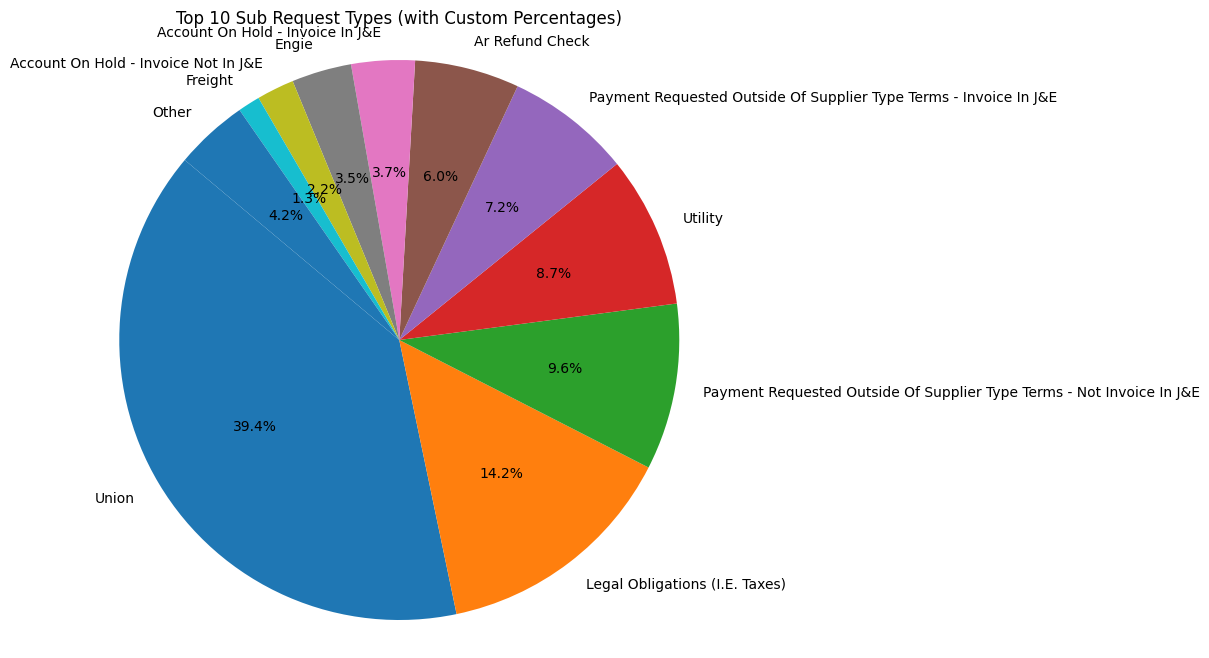

In [37]:
# remove duplicates and strange entries safely
df = df.copy()

# Remove leading spaces and standardize casing
df['sub_request_type'] = df['sub_request_type'].astype(str).str.strip().str.title()

# Remove weird date entry if present
df = df[df['sub_request_type'] != '2025-05-30 00:00:00']

# Now manually normalize Engie and other similar entries
df['sub_request_type'] = df['sub_request_type'].replace({
    'Engie Bills': 'Engie',
    'Engie Bill': 'Engie',
    'Engie  ': 'Engie',
    'Engie Bills ': 'Engie',
    'Engie ': 'Engie',
    'Engie ': 'Engie',
    'Fright': 'Freight',
    'Donation / Contribution': 'Donation/Contribution',
    'Excel Upload ': 'Excel Upload',
    'Payment Requested Outside Of Supplier Type Terms -  Invoice In J&E':
        'Payment Requested Outside Of Supplier Type Terms - Invoice In J&E',
    'Payment Requested Outside Of Supplier Type Terms -  Invoice Not In J&E':
        'Payment Requested Outside Of Supplier Type Terms - Invoice Not In J&E'
})

# We calculate this implied total:
implied_total = 3944 / 0.394

# Now, we calculate all percentages based on this new implied total
data_counts = df['sub_request_type'].value_counts()
labels = list(data_counts.keys())
# remove the parentheses from .values()
percentages = [(count / implied_total) * 100 for count in data_counts] # <<< CORRECTED LINE

# We will plot the top 10 categories and group the rest into "Other"
top_10_labels = labels[:10]
top_10_percentages = percentages[:10]

# Sum the percentages of the remaining categories
other_percentage = sum(percentages[10:])
top_10_labels.append('Other')
top_10_percentages.append(other_percentage)


# Display the pie chart using these custom-calculated percentages
plt.figure(figsize=(10, 8))
plt.pie(
    top_10_percentages,
    labels=top_10_labels,
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Top 10 Sub Request Types (with Custom Percentages)')
plt.axis('equal')
plt.savefig("custom_percentage_pie_chart.png", bbox_inches='tight')
plt.show()


- **Union** – **39.4%** of the total requests
- **Legal Obligations (i.e. Taxes)** – **14.2%**
- **Payment Requested Outside of Supplier Type Terms - NOT Invoice in J&E** – **9.6%**
- **Utility** – **8.7%**
- **Payment Requested Outside of Supplier Type Terms - Invoice in J&E** – **7.2%**
- **AR Refund Check** – **6.0%**
- **Account on Hold - Invoice in J&E** – **3.7%**
- **Engie Bills** – **3.5%**
- **Account on Hold - Invoice NOT in J&E** – **2.2%**
- **FRIGHT** – **1.3%**

>  **Insight:** The majority of requests fall under **Union**, which dominates the pie chart. Followed by legal obligations and payment processing issues, these categories highlight key operational or financial process concerns.

___